In [1]:
import dgl
import numpy
import torch
import networkx as nx
import itertools
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import matplotlib.animation as animation
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
def build_graph():
    # source
    src = numpy.array([1, 1, 1, 2])
    
    # destination
    dst = numpy.array([2, 0, 4, 3])

    # edges:
    # default -> directional
    # make them bi-directional
    u = numpy.concatenate([src, dst])
    v = numpy.concatenate([dst, src])
    
    # create a graph object
    return dgl.graph((u, v))

In [3]:
# print information
graph = build_graph()
print(f'Nodes: {graph.number_of_nodes()}')
print(f'Edges: {graph.number_of_edges()}')

Nodes: 5
Edges: 8


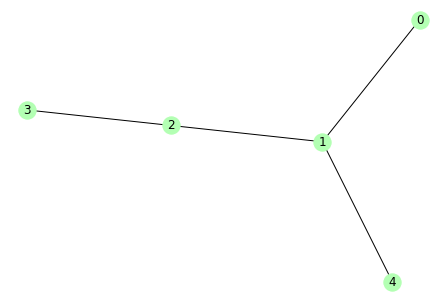

In [4]:
# visualize the graph
nx_graph = graph.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, 1, .7]])

In [5]:
# assign features to node
embeddings = nn.Embedding(5, 5)
graph.ndata['feat'] = embeddings.weight

In [6]:
graph.ndata

{'feat': Parameter containing:
tensor([[ 1.5376,  1.4223,  0.4889,  0.2984,  1.9836],
        [-1.5045, -1.0873,  0.8967, -1.3912,  0.5421],
        [-1.2115,  0.2032,  0.8320, -1.4135,  0.8375],
        [ 1.4693,  1.8105,  0.9151, -1.9801,  0.4434],
        [ 1.0603,  1.0188, -1.3450,  0.5283,  0.1358]], requires_grad=True)}

In [7]:
# define graph convolutional network
class GCN(nn.Module):
    
    def __init__(self, in_features, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_features, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

In [8]:
# create model
network = GCN(5, 3, 2)

In [9]:
# preparation and initialization
inputs = embeddings.weight
labeled_nodes = torch.tensor([0, 3])
labels = torch.tensor([0, 1])

In [26]:
# training
optimizer = torch.optim.Adam(itertools.chain(network.parameters(), embeddings.parameters()), lr=0.01)
all_logits = []

for epoch in range(1):
    logits = network(graph, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    print(logits)
    print(logp)
    print(logp[labeled_nodes])
    print(labels)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch:3.0f} | Loss: {loss:.4f}')

tensor([[ 2.3066, -1.3436],
        [-0.8947,  0.0951],
        [ 1.4600, -0.7790],
        [-0.5841,  0.5841],
        [ 2.3066, -1.3436]], grad_fn=<AddBackward0>)
tensor([[-0.0257, -3.6759],
        [-1.3058, -0.3160],
        [-0.1013, -2.3402],
        [-1.4389, -0.2708],
        [-0.0257, -3.6759]], grad_fn=<LogSoftmaxBackward>)
tensor([[-0.0257, -3.6759],
        [-1.4389, -0.2708]], grad_fn=<IndexBackward>)
tensor([0, 1])
tensor(0.1482, grad_fn=<NllLossBackward>)
Epoch   0 | Loss: 0.1482


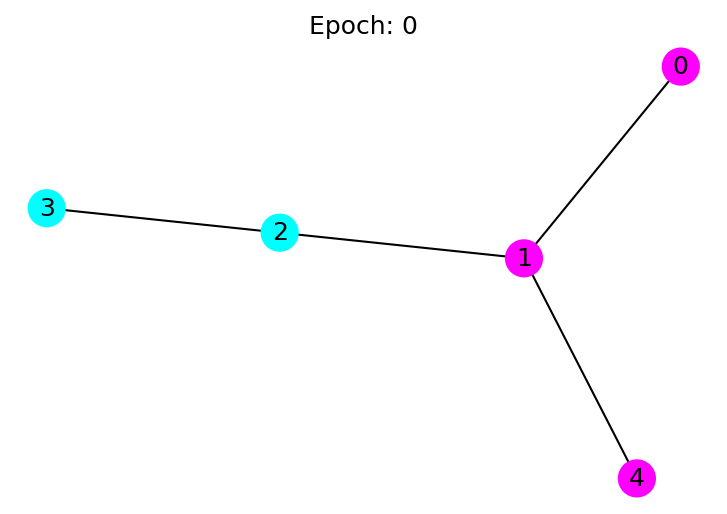

In [22]:
# visualization
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    
    pos = nx.kamada_kawai_layout(nx_graph)
    colors = []
    
    for v in range(5):
        # pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
        
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Epoch: {i}')
    nx.draw_networkx(nx_graph.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)

nx_graph = graph.to_networkx().to_undirected()
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)
# plt.close()

In [12]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
ani.save('animation.mp4', writer = 'ffmpeg', fps = 60)  